In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import h5py
base_path = '/storage/brno12-cerit/home/tslaninakova/sisap-challenge/data/pca32v2/100K'
data_path = f'{base_path}/dataset.h5'
%time f = h5py.File(data_path, 'r')

CPU times: user 28 µs, sys: 3.54 ms, total: 3.57 ms
Wall time: 62.2 ms


In [3]:
len(f['pca32'])

100000

In [4]:
%time loaded_data = f['pca32'][:, :]

CPU times: user 0 ns, sys: 10.8 ms, total: 10.8 ms
Wall time: 375 ms


## Goal:
- the laziest (yet working) implementation possible, piggybacking on dynamiclmi

In [5]:
## Split using kmedoids

In [6]:
from li.BulkLMI import BulkLMI
import pandas as pd

In [7]:
blmi = BulkLMI()
data = pd.DataFrame(loaded_data)
data.index += 1
%time blmi.insert(data)

CPU times: user 23.9 ms, sys: 3.98 ms, total: 27.9 ms
Wall time: 28 ms


In [8]:
blmi.dump_structure()

,type,children
key,,
"(0,)",LeafNode,100000


In [9]:
import logging

In [10]:
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s][%(levelname)-5.5s][%(name)-.20s] %(message)s'
)
LOG = logging.getLogger(__name__)


In [11]:
info_df = pd.DataFrame([], columns=['op', 'time-taken', 'size', '#-objects'])
%time info_df = blmi.deepen(blmi.nodes[(0, )], 10, info_df)

[2023-06-30 16:00:34,430][INFO ][numexpr.utils] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[2023-06-30 16:00:34,432][INFO ][numexpr.utils] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2023-06-30 16:00:34,457][INFO ][li.BulkLMI.BulkLMI] Epochs: 1000, step: 100
[2023-06-30 16:00:34,834][INFO ][li.BulkLMI.BulkLMI] Epoch 100 | Loss 0.0006194201996549964
[2023-06-30 16:00:35,154][INFO ][li.BulkLMI.BulkLMI] Epoch 200 | Loss 0.0002714135334827006
[2023-06-30 16:00:35,476][INFO ][li.BulkLMI.BulkLMI] Epoch 300 | Loss 0.0001527736458228901
[2023-06-30 16:00:35,726][INFO ][li.BulkLMI.BulkLMI] Epoch 400 | Loss 9.82462297542952e-05
[2023-06-30 16:00:35,951][INFO ][li.BulkLMI.BulkLMI] Epoch 500 | Loss 6.800670234952122e-05
[2023-06-30 16:00:36,183][INFO ][li.BulkLMI.BulkLMI] Epoch 600 | Loss 4.9997601308859885e-05
[2023-06-30 16:00:36,406][INFO ][li.BulkLMI.BulkLMI] Epoch 7

CPU times: user 14.2 s, sys: 1.49 s, total: 15.7 s
Wall time: 16.5 s


In [12]:
%%time
queries_path = f'{base_path}/query.h5'
f2 = h5py.File(queries_path, 'r')
loaded_queries = f2['pca32'][:, :]

CPU times: user 4.64 ms, sys: 76 µs, total: 4.72 ms
Wall time: 107 ms


## Check that the model has high confidence in one bucket per one query

In [214]:
%%time

raw_preds = blmi.nodes[(0, )].nn.predict_proba(
    data_X_to_torch(loaded_queries)
)

CPU times: user 129 ms, sys: 52 µs, total: 129 ms
Wall time: 129 ms


In [215]:
np.sum(np.max(raw_preds, axis=1) < 0.8)

362

In [251]:
pd.Series(np.max(raw_preds, axis=1))

0       0.999983
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
9995    1.000000
9996    1.000000
9997    1.000000
9998    0.999998
9999    0.864658
Length: 10000, dtype: float32

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

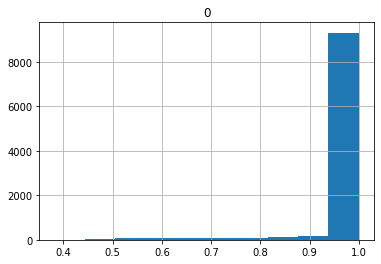

In [216]:
pd.DataFrame(np.max(raw_preds, axis=1)).hist()

In [111]:
%%time
gt_path = f'/storage/brno12-cerit/home/tslaninakova/sisap-challenge/data/groundtruth-100K.h5'
f3 = h5py.File(gt_path, 'r')
loaded_gt = f3['knns'][:, :]

CPU times: user 4.58 ms, sys: 4.03 ms, total: 8.62 ms
Wall time: 191 ms


In [218]:
raw_preds[2]

array([1.4910216e-15, 7.8926550e-27, 3.3901689e-16, 2.4088171e-17,
       1.7961142e-24, 1.0153153e-23, 7.5044255e-08, 9.9998260e-01,
       1.7287633e-05, 5.7575465e-14], dtype=float32)

<AxesSubplot:>

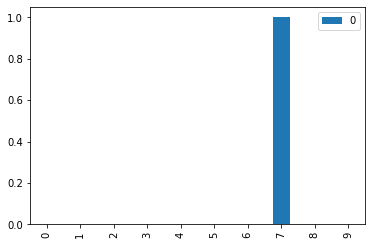

In [233]:
pd.DataFrame(raw_preds[0]).plot.bar()

In [224]:
loaded_gt[1]

array([14347, 82848, 79302, 85923,  6016, 67067, 29567, 54566, 34591,
       11620, 53783, 88026, 74917, 25913, 84845, 57931, 78536, 63598,
       19583, 45013,  3794, 79455, 23304, 64073, 21194, 39041, 64714,
       85541, 10588, 32001, 74891, 45443, 32634, 65660, 30660, 36013,
       13270, 99164,  7423, 71270, 67096, 60992, 92178, 89050, 48848,
       98619, 73628,  4071, 69824, 52696, 85241, 77697, 97132, 69221,
       54159, 94008,  1109, 80110, 34495, 77204, 79171, 68366, 79697,
        5732, 57784, 80630, 82986, 54903, 24140, 60239, 64347, 93839,
       90006, 22818, 66810, 32540, 69770, 42166, 88542, 51747, 64995,
       25579, 39089, 71087, 79761, 98731, 88318,  8116, 69048, 74671,
       79591, 11637, 80269, 71577, 45876,  3581, 48943, 78719, 78261,
       24809], dtype=int32)

In [243]:
raw_preds2 = blmi.nodes[(0, 7)].nn.predict_proba(
    data_X_to_torch(loaded_queries)
)

<AxesSubplot:>

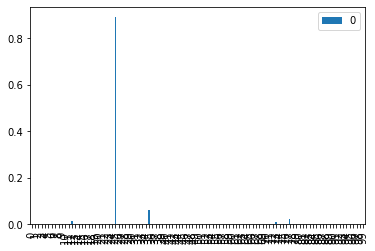

In [244]:
pd.DataFrame(raw_preds2[0]).plot.bar()

In [248]:
np.argsort(raw_preds2[0])

array([91,  0, 75, 93, 40, 86, 66, 99, 62, 47, 22, 83, 50, 76, 16,  5,  8,
       92, 72, 61, 37, 89, 70, 41, 21, 28,  7, 33, 98, 46, 19, 78, 44, 32,
       15,  9, 67, 94, 96, 68,  3, 97, 10, 51, 53, 63,  4, 87, 71, 18, 65,
       74, 79, 31, 36, 88, 57, 69, 90, 82, 27,  2, 26, 81, 45, 24,  6, 85,
       20, 84,  1, 13, 55, 52, 64, 54, 34, 17, 56, 48, 38, 23, 11, 39, 42,
       60, 49, 80, 95, 43, 30, 14, 58, 29, 59, 73, 12, 77, 35, 25])

In [246]:
for i in range(100):
    print(i, np.intersect1d(loaded_gt[0], np.array(blmi.nodes[(0, 7, i)].object_ids)))

0 []
1 [4327]
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 [83736 87457]
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 [20333]
25 [17544 22337 25525 35693 42586 52102 76538 79172 94426]
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 [12401 45784 64156 92501]
36 []
37 []
38 [15735 36442]
39 []
40 []
41 []
42 []
43 [86179]
44 []
45 []
46 []
47 []
48 []
49 [  231  4415 13493 31649 40382 55218 55412 60559 60622 64728 73074 80913
 86341 91179]
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 [ 1708 67226 87037]
59 [ 5985 22973 26294 64253 70410 73879 74173 94073 99973]
60 []
61 [68450]
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 [ 7180 13236 15425 16711 20970 21690 23975 35205 38159 71849 74573 76553
 79896 82381 83588]
74 []
75 []
76 []
77 [ 5492 24314 52857 63839 95028]
78 []
79 [898]
80 [19745 23884]
81 []
82 [5414]
83 []
84 []
85 [80243]
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 

In [229]:
%%time
np.argsort(
    raw_preds[2]
)

CPU times: user 131 µs, sys: 9 µs, total: 140 µs
Wall time: 144 µs


array([0, 1, 2, 4, 5, 6, 7, 8, 9, 3])

In [204]:
np.intersect1d(loaded_gt[], np.array(blmi.nodes[(0, 5)].object_ids))

array([ 4415,  6911, 15735, 16711, 18967, 20970, 26294, 35693, 36442,
       53818, 79753, 87037, 91179])

In [ ]:
data/groundtruth-100K.h5

In [ ]:
%%time
for i, leaf in enumerate(blmi.get_leaf_nodes_pos()):
    info_df = blmi.deepen(
        blmi.nodes[leaf],
        100,
        info_df
    )

In [14]:
blmi.dump_structure()

,type,children
key,,
"(0,)",InnerNode,10
"(0, 0)",InnerNode,100
"(0, 0, 0)",LeafNode,291
"(0, 0, 1)",LeafNode,51
"(0, 0, 2)",LeafNode,45
...,...,...
"(0, 9, 95)",LeafNode,100
"(0, 9, 96)",LeafNode,93
"(0, 9, 97)",LeafNode,130


In [15]:
queries_path = 'data/pca32v2/10M/query.h5'
%time f2 = h5py.File(queries_path, 'r')

CPU times: user 0 ns, sys: 1.97 ms, total: 1.97 ms
Wall time: 66.4 ms


In [121]:
%time loaded_queries = f2['pca32'][:, :]

CPU times: user 869 µs, sys: 0 ns, total: 869 µs
Wall time: 874 µs


In [35]:
loaded_queries[0]

array([-0.06877425, -0.11037602,  0.05646035, -0.11508854, -0.03577028,
        0.09110859,  0.07477964,  0.10778218,  0.04116842,  0.00877987,
       -0.06257925, -0.17031246,  0.00780125, -0.099485  ,  0.04967897,
       -0.12064676,  0.0035742 , -0.07642894,  0.08400699, -0.03188556,
       -0.01020392,  0.07147753, -0.01378688, -0.10539152, -0.00040444,
       -0.00291365,  0.12945361,  0.05624911,  0.00785595,  0.01020052,
        0.06252866, -0.00992952], dtype=float32)

In [16]:
from li.model import NeuralNetwork, data_X_to_torch, data_to_torch

In [18]:
import numpy as np

In [ ]:
res = blmi.nodes[(0, )].nn.predict_proba(data_X_to_torch(loaded_queries))

In [113]:
res = blmi.nodes[(0, )].nn.predict_proba(data_X_to_torch(loaded_queries))

/auto/brno12-cerit/nfs4/home/tslaninakova/sisap-challenge/repo/search/li/model.py:154: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = nnf.softmax(outputs)


In [126]:
sum(raw_preds[0])

0.9999999682348432

In [18]:
import numpy as np

ImportError: cannot import name 'data_X_to_torch'

In [21]:
loaded_queries.shape

(10000, 32)

In [23]:
    blmi.nodes[(0, )].nn.predict_proba(
        data_X_to_torch(loaded_queries)
    )

(array([[1.7582202e-01, 2.8572857e-15, 1.7046597e-12, ..., 1.1983315e-05,
         5.9401941e-13, 1.3378007e-20],
        [4.8432039e-21, 3.5637514e-21, 2.0142326e-28, ..., 4.2503068e-37,
         6.2255156e-28, 1.3117322e-12],
        [3.7722401e-19, 9.3646389e-33, 1.0000000e+00, ..., 9.3976630e-27,
         2.0487810e-19, 4.5789113e-23],
        ...,
        [2.1425209e-20, 4.5981435e-17, 9.3060073e-21, ..., 6.7475746e-08,
         1.2581496e-20, 3.9797575e-24],
        [5.4887380e-05, 8.1292950e-25, 5.5970184e-15, ..., 1.0924608e-09,
         1.3399331e-21, 9.3531281e-01],
        [2.7568534e-18, 5.7732496e-22, 1.3162696e-18, ..., 8.8264013e-27,
         1.5758556e-10, 3.1159263e-18]], dtype=float32),
 array([   0,    1,    2, ..., 9997, 9998, 9999]))

In [19]:
%%time
predicted_categories = np.argsort(
    blmi.nodes[(0, )].nn.predict_proba(
        data_X_to_torch(loaded_queries)
    )[0], axis=1
)


CPU times: user 7.58 ms, sys: 4 ms, total: 11.6 ms
Wall time: 11.6 ms


In [99]:
raw_preds.shape

(10000, 10)

In [96]:
predicted_categories[0]

array([7, 5, 1, 4, 6, 0, 3, 8, 9, 2])

In [102]:
sum(raw_preds[0])

2.9094968258779387e-26

In [101]:
raw_preds[0]

array([7.6310126e-35, 2.6850981e-40, 2.8123551e-26, 1.1472881e-34,
       3.7171684e-40, 1.2891946e-43, 2.5601896e-36, 7.0064923e-45,
       1.5954410e-33, 9.7141576e-28], dtype=float32)

In [140]:
raw_preds[10][np.where(raw_preds[10] > 0.1)[0]]

array([1.], dtype=float32)

In [136]:
raw_preds[10][np.where(raw_preds[10] > 0.1)]

array([1.], dtype=float32)

<AxesSubplot:>

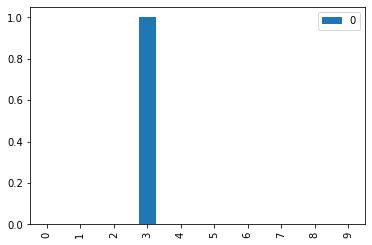

In [142]:
pd.DataFrame(raw_preds[10]).plot.bar()

In [92]:
predicted_categories

array([[7, 5, 1, ..., 8, 9, 2],
       [9, 1, 6, ..., 7, 3, 8],
       [0, 9, 8, ..., 5, 6, 1],
       ...,
       [3, 5, 6, ..., 8, 2, 0],
       [0, 9, 5, ..., 3, 2, 8],
       [6, 1, 3, ..., 9, 2, 8]])

In [21]:
categories = np.unique(predicted_categories)

In [55]:
loaded_queries.shape

(10000, 32)

In [23]:
bucket = 0

In [24]:
for category in categories:
    cat_idxs = np.where(predicted_categories[:, -(bucket+1)] == category)
    predicted_categories_lvl2 = np.argsort(
        blmi.nodes[(0, category)].nn.predict_proba(
            data_X_to_torch(loaded_queries[cat_idxs])
        )[0], axis=1
    )
    break

In [66]:
predicted_categories_lvl2

array([[49, 94, 33, ..., 30, 56, 47],
       [44, 57, 49, ..., 85, 10, 63],
       [41, 18, 70, ..., 11, 58, 59],
       ...,
       [65, 13, 41, ..., 46, 27, 12],
       [44, 62, 72, ..., 86, 38, 43],
       [18, 62, 73, ..., 50,  2, 85]])

In [68]:
predicted_categories_lvl2[:, -(bucket+1)].shape

(828,)

In [67]:
loaded_queries[cat_idxs].shape

(828, 32)

In [252]:
query = loaded_queries[0]

In [259]:
data_X_to_torch(query).dim()

1

In [27]:
from tqdm import tqdm

### Label encoder for buckets

In [28]:
%%time
mapping = blmi.dump_structure().query('type == "LeafNode"')
mapping.insert(0, 'bucket_id', range(0, len(mapping)))
mapping = mapping.bucket_id.to_dict()
reverse_mapping = {v: k for k, v in mapping.items()}

CPU times: user 60.7 ms, sys: 4.03 ms, total: 64.7 ms
Wall time: 64.8 ms


In [89]:
%%time
res_all = []
for i, query in tqdm(enumerate(loaded_queries)):
    bucket_ids = [[i, mapping[bucket]] for bucket in blmi.search(query, stop_condition=500)[0]]
    res_all.extend(bucket_ids)

10000it [00:09, 1095.06it/s]

CPU times: user 8.43 s, sys: 64 ms, total: 8.49 s
Wall time: 9.14 s


In [93]:
res_all = np.array(res_all)

In [100]:
d_anns = dict.fromkeys(range(0, 10_000))
d_dists = dict.fromkeys(range(0, 10_000))

In [101]:
%%time

for identified_bucket in tqdm(np.unique(res_all[:, 1])):
    queries_positions = res_all[res_all[:, 1] == identified_bucket][:, 0]
    queries_with_identified_bucket = loaded_queries[queries_positions]
    objects_in_bucket = np.array(blmi.nodes[reverse_mapping[identified_bucket]].objects)
    object_id_in_bucket = np.array(blmi.nodes[reverse_mapping[identified_bucket]].object_ids)
    res = pairwise_cosine(
        queries_with_identified_bucket, objects_in_bucket
    )
    ann_relative = res.argsort()
    res_sorted = np.take_along_axis(res, ann_relative, axis=1)
    #res_df = pd.DataFrame(res, columns=object_id_in_bucket)
    #res_df.index = queries_positions
    #es_all = pd.concat([res_all, res_df], axis=1)

    for i, (q, r) in enumerate(zip(queries_positions, res)):
        if d_anns[q] is None:
            d_anns[q] = object_id_in_bucket[ann_relative[i]]
            d_dists[q] = res_sorted[i]
        else:
            d_anns[q] = np.hstack((d_anns[q], object_id_in_bucket[ann_relative[i]]))
            d_dists[q] = np.hstack((d_dists[q], res_sorted[i]))

    #seq_res_all.append()
    """
    assert res.shape[1] <= 500
    #res = res[:, :500]
    ann_relative = res.argsort()
    res_sorted = np.take_along_axis(res, ann_relative, axis=1)
    try:
        max_index = max(np.where(anns_final[queries_positions] != -1)[1])
    except ValueError:
        max_index = 1
    print(f'max index: {max_index}')
    break
    #for i, query_position in enumerate(queries_positions):
    #    anns_list[query_position].extend(object_id_in_bucket[ann_relative[i]])
    anns_final[queries_positions][:500] = np.pad(ann_relative, [(0, 0), (0, 16*500)], 'constant', constant_values=(-1))
    dists_final[queries_positions][:500] = np.pad(res_sorted, [(0, 0), (0, 16*500)], 'constant', constant_values=(10_000))
    """

100%|██████████| 993/993 [00:01<00:00, 536.74it/s]

CPU times: user 1.44 s, sys: 28.4 ms, total: 1.47 s
Wall time: 1.86 s


In [114]:
k = 100
idx_sorted = d_dists[0].argsort(kind='stable')[:k]
idx_sorted

array([ 91,  92,  93,  94, 185,  95, 186, 274, 275,  96, 379, 276,  97,
       277, 278, 187, 443,  98,  99,   0, 380, 100, 279, 101, 280, 188,
       189, 444, 102, 103, 104, 105, 106, 381, 107, 108, 281, 109, 110,
       190, 111, 282, 445, 382, 446, 112, 283, 284, 383, 285, 113, 191,
       286, 114, 447, 115, 384, 287, 116, 117, 385, 288, 386, 118, 119,
       289, 448, 290, 192, 120, 193, 291, 292, 121, 293, 449, 294, 122,
       123, 194, 387, 195, 388, 389, 124, 390, 125, 126, 391, 295, 196,
       296, 392, 393, 297, 298, 299, 300, 301, 302])

In [115]:
d_dists[0][idx_sorted]

array([0.11132693, 0.12166536, 0.12826711, 0.13174927, 0.13217294,
       0.13277352, 0.14000309, 0.14461923, 0.15164298, 0.15488857,
       0.15859717, 0.16162956, 0.1624754 , 0.16926277, 0.17129964,
       0.17150682, 0.1724832 , 0.17310399, 0.17365974, 0.17378002,
       0.1738388 , 0.17579103, 0.17657101, 0.1803363 , 0.18241268,
       0.18399197, 0.18607843, 0.18761033, 0.18899655, 0.18927264,
       0.1937269 , 0.20124173, 0.2026459 , 0.2042849 , 0.20522511,
       0.20785218, 0.20821685, 0.21041942, 0.21047169, 0.2113486 ,
       0.21256834, 0.21274072, 0.21334618, 0.2139656 , 0.21425837,
       0.21439654, 0.21679503, 0.22174066, 0.22324175, 0.22334021,
       0.22388256, 0.22480756, 0.22544879, 0.22559953, 0.22610956,
       0.22766024, 0.22824681, 0.22937793, 0.22948587, 0.23076671,
       0.23136997, 0.23277849, 0.23493785, 0.23598534, 0.23709565,
       0.239461  , 0.24006414, 0.24070662, 0.24142587, 0.24180543,
       0.24212575, 0.24315977, 0.24351484, 0.24430746, 0.24450

In [116]:
d_anns[0][idx_sorted]

array([41079, 92501, 82795, 92811, 22337, 79896, 83736, 11781, 11441,
       41370, 50294, 24532, 15455, 13032, 45784, 20213, 41312, 69015,
       53971, 97655, 74338, 12401, 19961, 24314, 24874, 57876, 79172,
       13236, 74173, 67030, 45346, 38159, 99104, 92706, 44952, 33397,
        8420, 97387, 96585, 99941, 99973, 29649, 75694, 49088, 93336,
       12161, 60713, 50761, 77349, 32656, 63157, 17356, 20970, 42014,
       42987, 73726, 75733, 75745, 83523, 38180,  6417, 84933, 40380,
       53017, 76538, 94229, 52857, 64156, 53199, 11490, 46412, 43410,
       88936, 61308, 62157, 25525, 83621, 94426, 51552, 94241,  5492,
       52552,  9384, 73968, 38033,  5272, 29316, 95397, 75927,  6945,
       81076, 16061, 19720, 21074, 37889, 65794, 33748, 72401, 83990,
       86248])

In [119]:
np.intersect1d(loaded_gt[0], d_anns[0][idx_sorted]).shape

(30,)

In [113]:
loaded_gt[0]

array([79172, 15735, 22337,   231, 74173, 41079, 38159, 71849, 69015,
       92811, 99973, 79896, 13236, 64156, 86179, 55218, 60622, 64728,
       86341, 63839, 52857,   885, 83736, 87457, 36442, 24314, 73879,
        5985, 20970, 60559,  5414, 26294, 42586, 41370, 22973,  4415,
       23975, 82381, 15425, 79753, 19745, 74573, 40382,  8735, 70297,
       23884, 92501, 66709, 91232, 61308, 94073,  4327, 25525,  7180,
       12401,  5451, 59683, 17544, 53818, 52102, 85602,   898, 76553,
       18967, 37889, 50123, 80243, 35693, 73074, 31649, 55412, 13493,
       67226, 21472, 81544, 70033, 91179, 97387, 94426, 76538, 64253,
       29033, 87037, 38033, 80913, 70410, 83588, 44952,  6911, 65794,
       45784,  5492, 35205, 21690, 16711, 95028, 19961,  1708, 68450,
       20333], dtype=int32)

In [ ]:
idx_sorted = d_dists[0].argsort(kind='stable', axis=1)[:, :k]
# indexes the final arrays with the sorted indices
# *_final arrays now have shape (queries.shape[0], k)
idx = np.ogrid[tuple(map(slice, dists_final.shape))]
idx[1] = idx_sorted
dists_final = dists_final[tuple(idx)]
anns_final = anns_final[tuple(idx)]


In [104]:
d_dists[0]

array([0.17378002, 0.3605494 , 0.46856803, 0.6289252 , 0.65206265,
       0.6666372 , 0.6783974 , 0.6883215 , 0.7001161 , 0.7030965 ,
       0.706066  , 0.71346486, 0.7171781 , 0.7208396 , 0.721431  ,
       0.7243774 , 0.7434631 , 0.7573956 , 0.75858736, 0.7688472 ,
       0.7739948 , 0.7766472 , 0.7815709 , 0.7853862 , 0.7907893 ,
       0.79115874, 0.7914661 , 0.7922906 , 0.79235476, 0.79758537,
       0.7982862 , 0.7986653 , 0.79881275, 0.7997116 , 0.8001335 ,
       0.8024083 , 0.8087257 , 0.81066513, 0.81270504, 0.8175447 ,
       0.8228152 , 0.8240747 , 0.827099  , 0.83256143, 0.834934  ,
       0.8387216 , 0.8395598 , 0.84190094, 0.8499301 , 0.85575247,
       0.8604746 , 0.8608321 , 0.864146  , 0.8701068 , 0.8733051 ,
       0.87557167, 0.8759448 , 0.8759695 , 0.8811133 , 0.88512295,
       0.8876426 , 0.90607846, 0.9212497 , 0.9243158 , 0.9243955 ,
       0.9340605 , 0.9465519 , 0.9491627 , 0.9585603 , 0.9611607 ,
       0.96749383, 0.9819918 , 0.9828195 , 0.98800534, 1.00449

In [51]:
len(seq_res_all)

993

In [53]:
seq_res_all[0].shape

(425, 291)

In [51]:
anns_final[queries_positions].shape

(172, 8000)

In [ ]:
anns_final[queries_positions][:, :500] = np.pad(ann_relative, [(0, 0), (0, 16*500)], 'constant', constant_values=(-1))

In [50]:
ann_relative.shape

(172, 43)

In [52]:
res[0]

array([0.74044925, 0.6198943 , 0.4426393 , 0.439124  , 0.4717793 ,
       0.4985193 , 0.38455868, 0.4467218 , 0.5428933 , 0.41881138,
       0.4009906 , 0.51014876, 0.6466647 , 0.4652685 , 0.34292692,
       0.33718348, 0.5066345 , 0.50183415, 0.7392156 , 0.35972703,
       0.8137438 , 0.45306224, 0.5065808 , 0.30858958, 0.53364754,
       0.61959165, 0.39716643, 0.31557763, 0.36970794, 0.55810094,
       0.4994421 , 0.61537176, 0.62205964, 0.5574581 , 0.465456  ,
       0.44837725, 0.52410376, 0.52498335, 0.6635529 , 0.6834788 ,
       0.5301356 , 0.44374007, 0.45452183], dtype=float32)

In [47]:
res.shape

(172, 43)

In [455]:
anns_list[0]

[73888,
 54204,
 58761,
 68824,
 74026,
 77886,
 79138,
 1507,
 77284,
 16580,
 95976,
 92606,
 38227,
 61929,
 13108,
 37540,
 1907,
 50224,
 71437,
 84744,
 52368,
 33756,
 49898,
 6391,
 9137,
 28213,
 44122,
 21867,
 1333,
 40773,
 2779,
 46945,
 31691,
 64678,
 37723,
 49090,
 38932,
 70390,
 17545,
 97973,
 49465,
 47223,
 81845,
 83863,
 5153,
 7443,
 82886,
 64807,
 17825,
 82392,
 29197,
 13482,
 12207,
 23670,
 98867,
 58620,
 64300,
 81764,
 65857,
 51972,
 91567,
 15621,
 90807,
 82556,
 3031,
 8435,
 51322,
 75312,
 45557,
 99069,
 42764,
 13027,
 66749,
 3792,
 33591,
 5678,
 44965,
 21430,
 93997,
 48363,
 23726,
 99846,
 57963,
 64221,
 99443,
 52113,
 99195,
 21391,
 21856,
 89462,
 64301,
 86749,
 40882,
 46889,
 60874,
 92128,
 34903,
 30060,
 86110,
 29468,
 55691,
 49292,
 63280,
 9203,
 38986,
 62417,
 19679,
 97446,
 32743,
 74665,
 67194,
 33738,
 25128,
 51774,
 66865,
 51647,
 92331,
 86638,
 89967,
 53650,
 6100,
 53750,
 81368,
 52904,
 94075,
 13689,
 81035

In [424]:
max(np.where(anns_final[queries_positions] != -1)[1])

45

In [426]:
anns_final[queries_positions][:, 46:]

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [ ]:
np.pad(ann_relative, [(0, 0), (0, 200-res.shape[1])], 'constant')

In [407]:
np.pad(ann_relative, [(0, 0), (0, 200-res.shape[1])], 'constant')

array([[13, 25, 14, ...,  0,  0,  0],
       [17, 29, 26, ...,  0,  0,  0],
       [25, 13, 19, ...,  0,  0,  0],
       ...,
       [10,  4, 43, ...,  0,  0,  0],
       [36, 20, 43, ...,  0,  0,  0],
       [ 7, 35, 32, ...,  0,  0,  0]])

In [415]:
anns_final[queries_positions]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [414]:
anns_final[queries_positions] != -1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [387]:
bucket_positions

array([ 763, 1539, 2351, 2535, 2800, 2866, 4347, 4521, 4661, 4881, 4956,
       5120, 5808, 6760, 7696, 8032, 9665, 9788])

In [382]:
npw_r = np.where(anns_final[bucket_positions] == 0)

In [384]:
npw_r[0], npw_r[1]

(array([ 0,  0,  0, ..., 17, 17, 17]),
 array([ 15,  46,  47, ..., 197, 198, 199]))

In [385]:
anns_final[bucket_positions][npw_r[0], npw_r[1]]

array([0., 0., 0., ..., 0., 0., 0.])

In [368]:
(anns_final[bucket_positions] == 0).shape

(18, 200)

In [373]:
np.ix_(anns_final[bucket_positions] == 0)

ValueError: Cross index must be 1 dimensional

In [374]:
anns_final[bucket_positions][anns_final[bucket_positions] == 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [375]:
anns_final[bucket_positions][...,anns_final[bucket_positions] == 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [358]:
anns_final[bucket_positions][0]

array([13., 25., 14., 22., 11., 19.,  7.,  8., 12., 41., 31., 26., 32.,
       24., 18.,  0., 34., 35., 28.,  6., 44.,  3., 39., 27., 15.,  4.,
       17., 43., 23., 10., 20.,  2., 21., 45., 16., 38., 37., 29.,  9.,
       30., 36.,  1., 42., 33., 40.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [354]:
anns_final

array([[ 12.,  39.,  25., ...,   0.,   0.,   0.],
       [ 19.,  17.,  43., ...,   0.,   0.,   0.],
       [ 84.,  41.,  88., ...,   0.,   0.,   0.],
       ...,
       [ 60., 113.,  93., ..., 184., 181., 144.],
       [151.,  24., 183., ..., 110., 163.,  17.],
       [ 95., 124., 109., ...,   0.,   0.,   0.]])

In [329]:
anns_final[res_all[res_all[:, 1] == 0][:, 0]] = np.pad(ann_relative, [(0, 0), (0, 200-25)], 'constant')

In [ ]:
%%time
res_all[res_all[:, 1] == 0]

In [312]:
res = pairwise_cosine(
    loaded_queries[res_all[res_all[:, 1] == 0][:, 0]], blmi.nodes[reverse_mapping[0]].objects
)

In [315]:
ann_relative = res.argsort()

In [316]:
ann_relative

array([[ 0,  1, 18, ..., 12,  3, 16],
       [ 9, 11,  2, ..., 24,  3, 13],
       [10, 24,  8, ..., 23, 17, 13],
       ...,
       [ 4, 15,  5, ..., 18, 11, 23],
       [11,  6, 10, ...,  5,  1, 13],
       [15,  4,  1, ..., 20, 18, 11]])

In [317]:
res_sorted = np.take_along_axis(res, ann_relative, axis=1)

In [318]:
res_sorted

array([[0.59467447, 0.64894956, 0.721488  , ..., 0.9253196 , 0.9390921 ,
        0.98928344],
       [0.15861797, 0.20232278, 0.20406294, ..., 0.46112722, 0.47672027,
        0.5393085 ],
       [0.6873648 , 0.7034833 , 0.7083878 , ..., 0.92428976, 0.92935526,
        0.9307698 ],
       ...,
       [0.51733375, 0.57165176, 0.58112013, ..., 0.8638049 , 0.91691333,
        0.9280122 ],
       [0.6637584 , 0.8009661 , 0.8196577 , ..., 1.0233    , 1.0390735 ,
        1.1452361 ],
       [0.5134368 , 0.5462156 , 0.6581563 , ..., 0.895819  , 0.9314033 ,
        0.9717914 ]], dtype=float32)

In [319]:
res_sorted.shape

(123, 25)

In [ ]:
res

In [325]:
ann_relative.shape

(123, 25)

In [328]:
np.pad(ann_relative, [(0, 0), (0, 200-25)], 'constant').shape

(123, 200)

In [313]:
res.shape

(123, 25)

In [ ]:
np.array(res_all[])

In [271]:
res_all[2]

[(0, 3, 79), (0, 0, 70)]

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time

def pairwise_cosine(x, y):
    return 1-cosine_similarity(x, y)

In [90]:
all_data = pd.DataFrame(loaded_data[:100_000])

def search_single(queries, predicted_categories, k=10):
    """ Search for k nearest neighbors for each query in queries.

    Parameters
    ----------
    queries : np.array
        Queries to search for.
    data : np.array
        Data to search in.
    k : int
        Number of nearest neighbors to search for.

    Returns
    -------
    anns : np.array
        Array of shape (queries.shape[0], k) with nearest neighbors for each query.
    final_dists_k : np.array
        Array of shape (queries.shape[0], k) with distances to nearest neighbors for each query.
    time : float
        Time it took to search.
    """
    nns = np.zeros((queries.shape[0], k), dtype=np.uint32)
    dists = np.zeros((queries.shape[0], k), dtype=np.float32)
    for cat in np.unique(predicted_categories):
        print(cat)
        #return
        cat_idxs = np.where(predicted_categories == cat)[0]
        # contents of (0, 0, 0)
        bucket_obj_indexes = blmi.nodes[((0, 0)) + tuple((cat, ))].object_ids #np.where(self.predictions == cat)[0]
        print(len(bucket_obj_indexes))#.shape)
        seq_search_dists = pairwise_cosine(queries[cat_idxs], all_data.loc[bucket_obj_indexes])
        print(seq_search_dists.shape)

        ann_relative = seq_search_dists.argsort()[:, :k]
        print(ann_relative.shape)
        nns[cat_idxs] = np.array(bucket_obj_indexes)[ann_relative] + 1
        dists[cat_idxs] = np.take_along_axis(seq_search_dists, ann_relative, axis=1)

    return dists, nns


In [91]:
dists, nns = search_single(loaded_queries[cat_idxs], predicted_categories_lvl2[:, -(bucket+1)], k=10)

0
76
(6, 76)
(6, 10)
1
102
(3, 102)
(3, 10)
2
7
(54, 7)
(54, 7)


ValueError: shape mismatch: value array of shape (54,7) could not be broadcast to indexing result of shape (54,10)

In [63]:
loaded_queries[cat_idxs].shape

(828, 32)

In [65]:
predicted_categories_lvl2

array([[49, 94, 33, ..., 30, 56, 47],
       [44, 57, 49, ..., 85, 10, 63],
       [41, 18, 70, ..., 11, 58, 59],
       ...,
       [65, 13, 41, ..., 46, 27, 12],
       [44, 62, 72, ..., 86, 38, 43],
       [18, 62, 73, ..., 50,  2, 85]])

In [51]:
predicted_categories[:, -(bucket+1)]

array([2, 8, 1, ..., 0, 8, 8])

In [ ]:
predicted_categories.shape

In [42]:
pred_categories = blmi.nodes[(0, )].nn.predict_proba(data_X_to_torch(loaded_queries[0]))

torch.Size([10])


In [43]:
bucket = 0
pred_categories[:, -(bucket+1)]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [41]:
pd.DataFrame(blmi.nodes[(0, )].nn.predict_proba(data_X_to_torch(loaded_queries[0]))).bar()

torch.Size([10])


AttributeError: 'DataFrame' object has no attribute 'bar'

In [36]:
blmi.search(loaded_queries[0], stop_condition=1)

AttributeError: 'NeuralNetwork' object has no attribute 'predict_single'

In [ ]:
### Goal: pick `n` pivots, make them as far away from each other as possible

In [11]:
import numpy as np
def get_random_indexes(size, dataset_size, seed):
    rng = np.random.default_rng(seed)
    random_idxs = rng.choice(range(dataset_size), size=(size), replace=False)
    random_idxs = np.sort(random_idxs)
    return random_idxs

idx = get_random_indexes(100, 10_000_000, 2023)
idx.shape

(100,)

In [13]:
from tqdm import tqdm
import gc
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time

def pairwise_cosine(x, y):
    r = cosine_similarity(x, y)
    return 1-cosine_similarity(x, y)

In [15]:
loaded_data[idx].shape

(100, 32)

### Choose random indexes, try more combinations for maximum separability

In [24]:
from tqdm import tqdm
max_idx = []
curr_max = 0.0001
for i in tqdm(range(1000)):
    idx = get_random_indexes(100, 10_000_000, 2023+i)
    sum_distances = np.sum(pairwise_cosine(loaded_data[idx], loaded_data[idx]))
    if curr_max < sum_distances:
        print(f'New max: {sum_distances}')
        curr_max = sum_distances
        max_idx = idx


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
max_idx = idx

In [27]:
idx

array([ 185321,  234653,  292222,  381677,  566723,  600284,  740565,
        867235,  900051, 1033366, 1044871, 1058727, 1403906, 1463850,
       1496680, 1657793, 1914290, 1985739, 2152561, 2181513, 2541923,
       2582441, 2762803, 2774061, 2873961, 2933642, 2965090, 3237394,
       3266257, 3294118, 3335269, 3335887, 3399452, 3430747, 3437788,
       3698427, 3752103, 4195891, 4304091, 4559483, 4586480, 4773710,
       4968399, 5003710, 5292731, 5380464, 5526795, 5570949, 5641847,
       5667377, 6197481, 6206438, 6274304, 6540740, 6544577, 6612350,
       6826490, 6831111, 6863057, 6885002, 6985042, 7163028, 7220946,
       7229246, 7266332, 7311872, 7373780, 7473792, 7491508, 7584210,
       7605908, 7609749, 7703936, 7742618, 7743605, 7754148, 7817008,
       7863949, 7980012, 8165405, 8527822, 8722572, 8761180, 8824108,
       8827635, 8848082, 8947908, 8959267, 8982641, 8985985, 9016244,
       9055639, 9155160, 9225834, 9260389, 9267319, 9547105, 9852251,
       9988332, 9998

In [17]:
res = pairwise_cosine(loaded_data[idx], loaded_data[idx])

In [20]:
np.sum(res)

9905.625

In [4]:
from li.model import Model
model = Model(input_dim=768, output_dim=100)

In [9]:
import torch
model.load_state_dict(torch.load('../models/clip768v2-emb-10M-best-model.pt'))
model.eval()

Model(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)

In [13]:
from li.model import data_X_to_torch, predict, get_device

In [14]:
%time predictions = predict(model, get_device(), data_X_to_torch(loaded_data))

CPU times: user 1min 59s, sys: 47.8 s, total: 2min 47s
Wall time: 2min 51s


In [15]:
predictions.shape

(10120191,)

In [47]:
from li.model import predict_proba

In [27]:
%time f2 = h5py.File('data/clip768v2/10M/query.h5', 'r')
[k for k in f2.keys()]

CPU times: user 460 µs, sys: 250 µs, total: 710 µs
Wall time: 16.1 ms


['emb']

In [28]:
%time loaded_queries = f2['emb'][:, :]

CPU times: user 1.36 ms, sys: 8.74 ms, total: 10.1 ms
Wall time: 10.2 ms


In [33]:
loaded_queries.shape

(10000, 768)

In [48]:
res = predict_proba(model, get_device(), data_X_to_torch(loaded_queries))

torch.Size([10000, 100])


In [66]:
from li.LearnedIndex10M import LearnedIndex

In [67]:
li = LearnedIndex(
    dataset_shape=(10_000_000, 768),
    n_categories=100
)

In [68]:
li.model = model

In [69]:
li.predictions = predictions

In [70]:
li.all_data =  loaded_data

In [74]:
%%time
search_res = li.search(loaded_queries, n_buckets=2)

bucket_obj_indexes: (70660,)
bucket_obj_indexes: (60431,)
bucket_obj_indexes: (155211,)
bucket_obj_indexes: (44668,)
bucket_obj_indexes: (44940,)
bucket_obj_indexes: (35358,)
bucket_obj_indexes: (78389,)
bucket_obj_indexes: (46592,)
bucket_obj_indexes: (120995,)
bucket_obj_indexes: (43151,)
bucket_obj_indexes: (145368,)
bucket_obj_indexes: (65688,)
bucket_obj_indexes: (42585,)
bucket_obj_indexes: (151551,)
bucket_obj_indexes: (142066,)
bucket_obj_indexes: (297296,)
bucket_obj_indexes: (109030,)
bucket_obj_indexes: (76712,)
bucket_obj_indexes: (85640,)
bucket_obj_indexes: (138392,)
bucket_obj_indexes: (97728,)
bucket_obj_indexes: (102276,)
bucket_obj_indexes: (150129,)
bucket_obj_indexes: (130399,)
bucket_obj_indexes: (140012,)
bucket_obj_indexes: (34989,)
bucket_obj_indexes: (136013,)
bucket_obj_indexes: (117123,)
bucket_obj_indexes: (89756,)
bucket_obj_indexes: (36506,)
bucket_obj_indexes: (108078,)
CPU times: user 5min 24s, sys: 27 s, total: 5min 51s
Wall time: 6min


In [76]:
search_res.shape

AttributeError: 'tuple' object has no attribute 'shape'

In [81]:
search_res[0].shape

(10000, 10)

In [80]:
search_res[1]

array([[ 1831320,  7535354,  7059014, ...,  9060635,  5509896,   210839],
       [  345243,   641543,   985275, ...,  4315057,  6363149,  4984877],
       [ 1385230,  8732144,  5079078, ...,  8500628,  7238113,  8391052],
       ...,
       [ 9550551,  9711325,  7029902, ...,  7054237,  8342966,  2623128],
       [10037932,  6595916,  4837121, ...,  2597817,  8233243,  3702635],
       [  497148,  8333824,  4361805, ...,  7069212,  7326701,  5715343]],
      dtype=uint32)

In [79]:
res[1].shape

(100,)

In [44]:
import numpy as np

In [46]:
res[0]

array([8.37511470e-05, 9.70561174e-04, 2.92020995e-04, 1.63676043e-04,
       8.52210354e-03, 7.81660492e-05, 1.58739305e-04, 6.29106071e-04,
       1.61633524e-03, 1.29780790e-04, 2.15484848e-04, 2.32058756e-05,
       1.46150356e-04, 2.36730743e-03, 1.38364936e-04, 1.30514824e-03,
       3.36273294e-03, 6.12222531e-04, 7.04983031e-05, 2.39886431e-04,
       1.60547465e-01, 1.37590361e-03, 2.52572994e-04, 1.07597589e-04,
       1.17151719e-03, 1.18067735e-04, 6.09984563e-04, 2.42916425e-03,
       3.16633657e-03, 4.98839188e-03, 1.29831792e-03, 8.74745543e-04,
       6.43437961e-04, 2.13510357e-03, 3.41637860e-05, 4.37771529e-03,
       2.57312728e-04, 7.93551953e-05, 2.43538052e-05, 1.43318884e-02,
       3.92020098e-04, 5.58090760e-05, 1.26074348e-03, 3.68411615e-02,
       4.93923551e-04, 1.02681312e-04, 1.21077430e-03, 2.71683879e-04,
       1.73655041e-02, 2.19049998e-05, 4.27135747e-05, 3.40649131e-05,
       1.30197138e-03, 2.38854840e-01, 3.57980825e-05, 4.40446602e-05,
      

In [45]:
np.argmax(res[0])

80

In [37]:
res[0].shape, res[1].shape

((10, 100), (10, 100))

In [16]:
predictions[:10]

array([38,  3, 58, 88, 84, 67, 13, 93, 75, 13])

In [ ]:
torch.save(model.state_dict(), f'{save_dir}/{wandb.run.name}/best-model.pt')


In [7]:
import numpy as np

In [9]:
def get_random_indexes(size, dataset_size, seed):
    rng = np.random.default_rng(seed)
    random_idxs = rng.choice(range(dataset_size), size=(size), replace=False)
    random_idxs = np.sort(random_idxs)
    return random_idxs

idx = get_random_indexes(1000, 10_000_000, 2023)
idx.shape

(1000,)

In [10]:
idx.shape == (1000, )

True

In [7]:
%time loaded_data = f['emb'][random_idxs, :]

CPU times: user 2.17 s, sys: 784 ms, total: 2.95 s
Wall time: 1min 19s


In [3]:
%time _ = f['emb'][:100_000, :]

CPU times: user 13.7 ms, sys: 110 ms, total: 124 ms
Wall time: 2.05 s


In [4]:
%time _ = f['emb'][:1_000_000, :]

CPU times: user 12.7 ms, sys: 1.03 s, total: 1.05 s
Wall time: 20.7 s


In [5]:
%time _ = f['emb'][:9_000_000, :]

CPU times: user 11.6 ms, sys: 16.1 s, total: 16.1 s
Wall time: 3min 10s


In [8]:
%time pred_data = f['emb'][:, :]

CPU times: user 211 ms, sys: 14.5 s, total: 14.7 s
Wall time: 4min 4s


In [ ]:
pred_data[]

In [ ]:
%time test_mem = f['emb'][random_idxs, :]

In [11]:
%%time
rng = np.random.default_rng(2023)
print(rng)
random_pivots = rng.choice(range(10_000_000), size=(1_000), replace=False)
pivot_indexes = np.sort(random_pivots)
pivot_data = f['emb'][pivot_indexes, :]

Generator(PCG64)
CPU times: user 1.1 s, sys: 529 ms, total: 1.63 s
Wall time: 10.8 s


In [12]:
pivot_data.shape

(1000, 768)

In [4]:
loaded_data.shape

(10000, 768)

In [43]:
from tqdm import tqdm
import gc
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time

def pairwise_cosine(x, y):
    r = cosine_similarity(x, y)
    print(r)
    return 1-cosine_similarity(x, y)

In [28]:
pivot_data[0].unsqueeze()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [36]:
loaded_data.shape

(1000, 768)

In [52]:
dists_all.shape

(2, 1000)

In [55]:
pivot_data.shape

(1000, 768)

In [59]:
training_data = np.empty((0,768))
training_data

array([], shape=(0, 768), dtype=float64)

In [44]:
%%time
dists_all = np.empty((0,1000))
training_data = np.empty((0,768))
prev = 0

for batch, pivot in zip(range(10_000, 10_000_000, 10_000), pivot_data):
    loaded_data = f['emb'][prev:batch, :]
    dists = np.argsort(cosine_similarity([pivot], loaded_data)[0])
    training_data_indexes = dists[-1000:]
    print(training_data_indexes.shape)
    break
    # take the 1000 most similar (argsort sorts from lowest to highest)
    dists_all = np.vstack((dists_all, prev+training_data_indexes))
    training_data = np.vstack((training_data, loaded_data[training_data_indexes]))
    del loaded_data
    gc.collect()
    prev = batch

NameError: name 'pivot_data' is not defined

In [75]:
training_data.shape

(999000, 768)

In [13]:
10_000_000 // 1000

10000

In [95]:
%%time
labels = np.array([np.array([i for j in range(1000)]) for i in range(999)])
labels = labels.reshape(labels.shape[0]*labels.shape[1])

CPU times: user 106 ms, sys: 2.27 ms, total: 108 ms
Wall time: 121 ms


In [69]:
dists_all.shape

(10, 1000)

In [87]:
from typing import Tuple
def get_device() -> torch.device:
    """ Gets the `device` to be used by torch.
    This arugment is needed to operate with the PyTorch model instance.

    Returns
    ------
    torch.device
        Device
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    torch.backends.cudnn.benchmark = True
    return device


def data_X_to_torch(data) -> torch.FloatTensor:
    """ Creates torch training data."""
    data_X = torch.from_numpy(np.array(data).astype(np.float32))
    return data_X


def data_to_torch(data, labels) -> Tuple[torch.FloatTensor, torch.LongTensor]:
    """ Creates torch training data and labels."""
    data_X = data_X_to_torch(data)
    data_y = torch.as_tensor(torch.from_numpy(labels), dtype=torch.long)
    return data_X, data_y

In [113]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, input_dim=768, output_dim=1000):
        super().__init__()
        self.layers = torch.nn.Sequential(
          torch.nn.Linear(input_dim, 128),
          torch.nn.ReLU(),
          torch.nn.Linear(128, output_dim)
        )

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        outputs = self.layers(x)
        return outputs

model = Model()
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
device = get_device()

In [98]:
%%time
data_X, data_y = data_to_torch(training_data, labels)
data_X.shape, data_y.shape

CPU times: user 756 ms, sys: 741 ms, total: 1.5 s
Wall time: 1.6 s


(torch.Size([999000, 768]), torch.Size([999000]))

In [135]:
def train(
    data_X: torch.FloatTensor,
    data_y: torch.LongTensor,
    model,
    optimizer,
    device,
    epochs=500,
):
    step = data_X.shape[0] // epochs // 10
    losses = []
    for ep in range(epochs):
        if ep % step == 0 and ep != 0:
            print(f'{time.time()} | Epoch {ep} | Loss {curr_loss.item()}')
        pred_y = model(data_X.to(device))
        curr_loss = loss(pred_y, data_y.to(device))
        losses.append(curr_loss.item())

        model.zero_grad()
        curr_loss.backward()

        optimizer.step()
    return losses, model


In [111]:
%%time
rng_offset = 1
rng = np.random.default_rng(2023+rng_offset)
rng_offset += 1
print(rng)
random_idxs = rng.choice(range(999000), size=(10_000), replace=False)

Generator(PCG64)
CPU times: user 99 ms, sys: 39.6 ms, total: 139 ms
Wall time: 139 ms


In [112]:
data_X_s = data_X[random_idxs]
data_y_s = data_y[random_idxs]
data_X_s.shape, data_y_s.shape

(torch.Size([10000, 768]), torch.Size([10000]))

In [136]:
model = Model(output_dim=np.unique(data_y_s).shape[0])
lr = 0.1
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
device = get_device()

In [137]:
%time losses, model = train(data_X_s, data_y_s, model, optimizer, device, epochs=100)

Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
CPU times: user 55.6 s, sys: 2.76 s, total: 58.3 s
Wall time: 59.8 s


In [141]:
def predict( model, device, data_X: torch.FloatTensor):
    """ Collects predictions for multiple data points (used in structure building)."""
    model = model.to(device)
    model.eval()

    all_outputs = torch.tensor([], device=device)
    with torch.no_grad():
        outputs = model(data_X.to(device))
        all_outputs = torch.cat((all_outputs, outputs), 0)

    _, y_pred = torch.max(all_outputs, 1)
    return y_pred.cpu().numpy()

In [142]:
predictions = predict(model, device, data_X_s)

In [146]:
data_y_s

tensor([515, 589, 280,  ..., 141, 934,  88])

In [145]:
predictions

array([515, 589, 280, ..., 141, 934,  88])

### we can let go of the training data

In [147]:
del training_data
gc.collect()

67

In [ ]:
# load everyting and then filter out whatever
%time pred_data = f['emb'][:, :]

In [157]:
%%time
predict_indexes = np.setdiff1d(np.arange(0, 10_000_000), dists_all.flatten())
predict_indexes.shape

CPU times: user 306 ms, sys: 367 ms, total: 672 ms
Wall time: 813 ms


(9001000,)

In [158]:
%%time
predict_indexes = np.sort(predict_indexes)
predict_indexes.shape

CPU times: user 102 ms, sys: 67.5 ms, total: 170 ms
Wall time: 172 ms


(9001000,)

In [159]:
predict_indexes[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
%%time
loaded_pred_data = f['emb'][predict_indexes, :]
loaded_pred_data.shape

In [ ]:
loaded_pred_data[:10]

In [155]:
dists_all.reshape((dists_all[0]*dists_all[1]))#.shape

ValueError: maximum supported dimension for an ndarray is 32, found 1000

In [ ]:
    def predict(self, data_X: torch.FloatTensor):
        """ Collects predictions for multiple data points (used in structure building)."""
        self.model = self.model.to(self.device)
        self.model.eval()

        all_outputs = torch.tensor([], device=self.device)
        with torch.no_grad():
            outputs = self.model(data_X.to(self.device))
            all_outputs = torch.cat((all_outputs, outputs), 0)

        _, y_pred = torch.max(all_outputs, 1)
        return np.array([self.model.output_neurons[label] for label in y_pred.cpu().numpy()])

    def predict_single(self, data_X: torch.FloatTensor):
        """ Collects predictions for a single data point (used in query predictions)."""
        self.model = self.model.to(self.device)
        self.model.eval()

        with torch.no_grad():
            outputs = self.model(data_X.to(self.device))

        prob = nnf.softmax(outputs, dim=0)
        top_prob, top_class = prob.topk(self.model.n_output_neurons, dim=0)
        top_prob = top_prob.cpu().numpy()
        return top_prob, np.array([self.model.output_neurons[label] for label in top_class.cpu().numpy()])
